In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import RFECV

from encoders import BinaryEncoder, DaysSinceEncoder, PercentToNumberEncoder, AmenitiesEncoder
#from encoders import ColumnDropper

sns.set()

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74110 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74110 non-null  int64  
 1   log_price               74110 non-null  float64
 2   property_type           74110 non-null  object 
 3   room_type               74110 non-null  object 
 4   amenities               74110 non-null  object 
 5   accommodates            74110 non-null  int64  
 6   bathrooms               73910 non-null  float64
 7   bed_type                74110 non-null  object 
 8   cancellation_policy     74110 non-null  object 
 9   cleaning_fee            74110 non-null  bool   
 10  city                    74110 non-null  object 
 11  description             74110 non-null  object 
 12  first_review            58246 non-null  object 
 13  host_has_profile_pic    73922 non-null  object 
 14  host_identity_verified  73922 non-null

In [2]:
df = pd.read_csv('data/train.csv')
df = df[df['log_price'] > 0]
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [96]:
def corr_direction_change(data, corr):
    df = data.select_dtypes(exclude=['object'])
    idx = 0
    for col in df:
        if corr[idx] < 0 :
            data[col] = -data[col]
        idx += 1

In [98]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=710)

corr_train = list(train_df.corr()['log_price'])

corr_direction_change(train_df, corr_train)
corr_direction_change(test_df, corr_train)

X_train = train_df.drop(columns=['log_price'])
y_train = train_df['log_price']

X_test = test_df.drop(columns=['log_price'])
y_test = test_df['log_price']

In [4]:
numeric_cols = ['accommodates', 'bathrooms', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds']
onehot_cols = ['property_type', 'room_type', 'bed_type', 'city', 'cleaning_fee']
ordinal_cols = ['cancellation_policy']
binary_cols = ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
date_cols = ['first_review', 'host_since', 'last_review']
percent_cols = ['host_response_rate']
amenities_cols = ['amenities']
drop_cols = ['id', 'description', 'latitude', 'longitude', 'name', 'neighbourhood', 'thumbnail_url', 'zipcode'] #usunąć potem zipcoda

In [5]:
numeric_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scale', StandardScaler())
])

binary_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='f')),
    ('encode', BinaryEncoder())
])

percent_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
    ('encode', PercentToNumberEncoder())
])

column_transformer = ColumnTransformer(
    [('numeric', numeric_pipe, numeric_cols),
     ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
     ('ordinal', OrdinalEncoder(categories=[['flexible', 'moderate', 'strict', 'super_strict_30', 'super_strict_60']]), ordinal_cols),
     ('binary', binary_pipe, binary_cols),
     ('date', DaysSinceEncoder(), date_cols), # missing values are handled inside encoder
     ('precent', percent_pipe, percent_cols),
     ('amenities', AmenitiesEncoder(), amenities_cols)],
    remainder='drop'
    #  ('dropper', ColumnDropper(columns=drop_cols), drop_cols)],
    # remainder='passthrough'
)

In [100]:
X_train_ = pd.DataFrame(column_transformer.fit_transform(X_train))
X_test_ = pd.DataFrame(column_transformer.transform(X_test))

In [101]:
X_train_.shape

(59288, 84)

In [102]:
X_test_.shape

(14822, 84)

In [103]:
import sklearn
import warnings

In [104]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names


In [105]:
X_train_.columns = get_feature_names(column_transformer)
X_test_.columns = X_train_.columns

Transformer impute (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
Transformer scale (type StandardScaler) does not provide get_feature_names. Will return input column names if available
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Transformer ordinal (type OrdinalEncoder) does not provide get_feature_names. Will return input column names if available
Transformer encode (type BinaryEncoder) does not provide get_feature_names. Will return input column names if available
Transformer date (type DaysSinceEncoder) does not provide get_feature_names. Will return input column names if available
Transformer encode (type PercentToNumberEncoder) does not provide get_feature_names. Will return input column names if available


In [106]:
import xgboost
import shap

In [107]:
def feature_engineering(model, X_train, X_test):
    shap_values = shap.TreeExplainer(model).shap_values(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=X_train.shape[1], show=False)
    plt.title("Feature importances based on shap value")
    plt.show()
    
    lista = []
    for i in range(X_train.shape[1]):
        col_sum = 0
        for j in range(X_train.shape[0]):
            col_sum += abs(shap_values[j][i])
        lista.append(col_sum/(X_train.shape[0] + 1))
    
    
    indexy = []
    for i in range(X_train.shape[1]):
        if(lista[i] <= 0.01):
            indexy.append(i)
    
    X_train.drop(X_train.columns[indexy], axis = 1, inplace = True)
    X_test.drop(X_test.columns[indexy], axis = 1, inplace = True)

In [108]:
from sklearn.metrics import mean_squared_error

In [109]:
xgb = xgboost.XGBRegressor(eval_metric = "merror")

In [110]:
xgb.fit(X_train_, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='merror', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [111]:
pred_train = xgb.predict(X_train_)

In [112]:
pred_test = xgb.predict(X_test_)

In [113]:
print("RMSE dla treningowego: " + str(mean_squared_error(y_train, pred_train)))
print("RMSE dla testowego: " + str(mean_squared_error(y_test, pred_test)))

RMSE dla treningowego: 0.1449988098532738
RMSE dla testowego: 0.1868979186017315


In [114]:
xgb.get_xgb_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 12,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'merror'}

In [115]:
xgb_fs = xgboost.XGBRegressor(eval_metric = "merror")

In [116]:
xgb_fs.fit(X_train_, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='merror', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [117]:
pred_train = xgb_fs.predict(X_train_)

In [118]:
pred_test = xgb_fs.predict(X_test_)

In [119]:
print("RMSE dla treningowego: " + str(mean_squared_error(y_train, pred_train)))
print("RMSE dla testowego: " + str(mean_squared_error(y_test, pred_test)))

RMSE dla treningowego: 0.1449988098532738
RMSE dla testowego: 0.1868979186017315


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


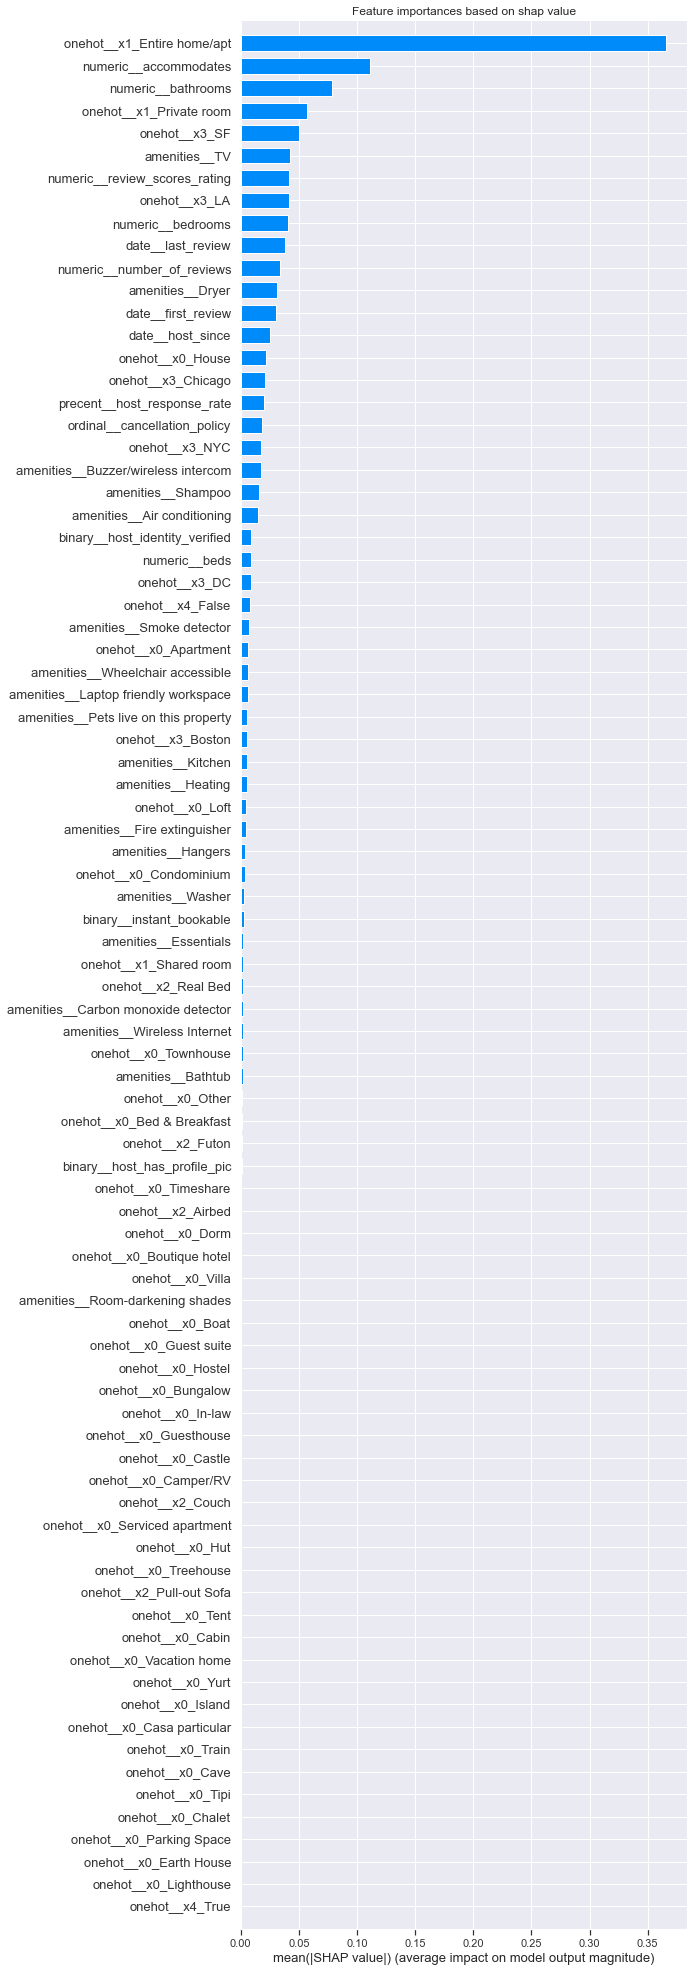

In [120]:
feature_engineering(xgb, X_train_, X_test_)

In [121]:
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [122]:
params = {"max_depth" : [i for i in range(4, 15)],
        "subsample" : [i/10.0 for i in range(6,10)],
        "eta" : [i/100 for i in range(2, 31, 3)],
         "alpha" : [i/10 for i in range(0, 4)],
         "gamma" : [i for i in range(0, 10)],
         "min_child_weight" : [i for i in range(0, 8)],
        "colsample_bytree" : [i/10.0 for i in range(3,10)],
          "n_estimators" : [i for i in range(100, 200, 10)]
         }

In [123]:
xgb = xgboost.XGBRegressor()

In [124]:
xgb_opt = RandomizedSearchCV(estimator=xgb, 
                             param_distributions=params, 
                            cv=5, 
                             n_jobs=4,
                             n_iter=100,
                             verbose=2,
                            scoring = 'neg_mean_squared_error',
                             random_state=1)

In [125]:
xgb_opt.fit(X_train_, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                        'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.7, 0.8, 0.9],
                                 

In [126]:
xgb_opt.best_params_

{'subsample': 0.9,
 'n_estimators': 170,
 'min_child_weight': 3,
 'max_depth': 12,
 'gamma': 1,
 'eta': 0.05,
 'colsample_bytree': 0.5,
 'alpha': 0.0}

In [127]:
final_xgb = xgb_opt.best_estimator_

In [128]:
pred_train = final_xgb.predict(X_train_)

In [129]:
pred_test = final_xgb.predict(X_test_)

In [130]:
print("RMSE dla treningowego: " + str(mean_squared_error(y_train, pred_train)))
print("RMSE dla testowego: " + str(mean_squared_error(y_test, pred_test)))

RMSE dla treningowego: 0.14450387934308273
RMSE dla testowego: 0.18861952766038187


In [131]:
import shap

100%|===================| 59237/59288 [16:49<00:00]        

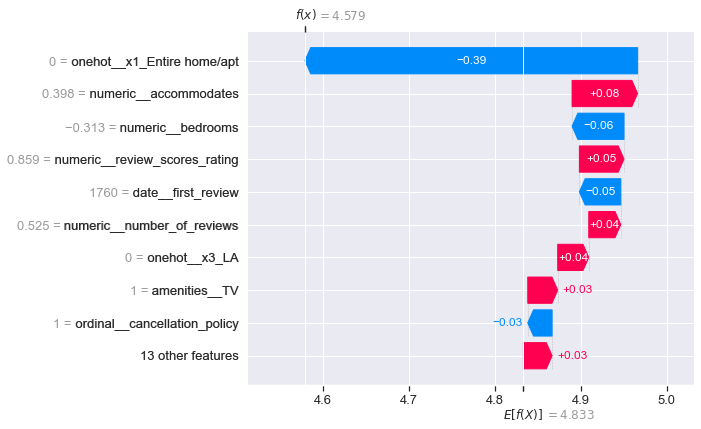

In [132]:
explainer = shap.Explainer(final_xgb, X_train_)
shap_values = explainer(X_train_)
shap.plots.waterfall(shap_values[0])

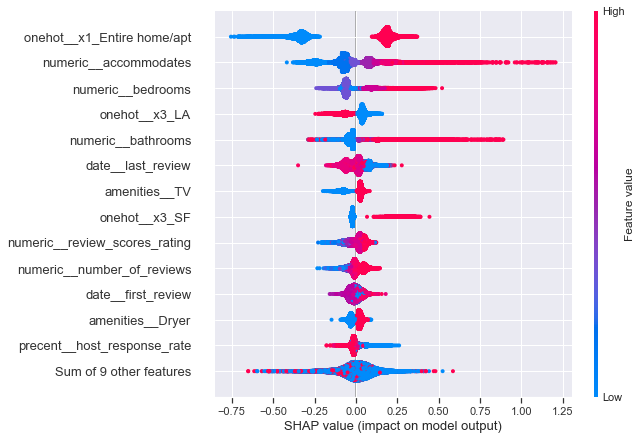

In [135]:
shap.plots.beeswarm(shap_values, max_display=14)